# ```hrr_cobot_robot``` tutorial 04 - Advanced ```cobot``` Handle


**This is the continuation of the tutorial 01-03 notebooks. Please understand how to read data and send simple commands from the cobot before continuing here
You can also find additional information about underlying docus and startup procedures**

**CHANGELOG**

v0.3

- imports changed 
- C++ compliance controller not checked / fully supported due to time restrictions
- bottom (exending API) removed 

## Imports / Packages needed

In [1]:
# packages needed for this tutorial
from pathlib import Path

# math and robotics
import numpy as np
import quaternion
from tqdm.notebook import tqdm, trange

# plotting 
import seaborn as sns
import matplotlib.pylab as plt

# ROS
import rospy

# hrr-cobot packages
import hrr_cobot_robot
import hrr_common
import hrr_controllers

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
%matplotlib notebook

In [2]:
hrr_common.utils.set_ros_environment(ros_master = 'hrrcobotLinux54')

current hostname:	hrrcobotLinux54
current IP:      	129.187.147.74
ROS-MASTER-URI:  	http://hrrcobotLinux54:11311


In [3]:
rospy.init_node("hrr_cobot_tutorial04")

## Hrr-Cobot Control interface

This tutorial outlines the usage of the HrrcobotControl class, which is an extension of the ```HrrCobotIf```
from the previous tutorial

In [4]:
# outcomment as needed
# ?hrr_cobot_robot.HrrCobotControl

In [5]:
cobot = hrr_cobot_robot.HrrCobotControl.from_ros("/hrr_cobot", compile_numba=False)

pybullet build time: May  8 2021 05:48:13


[rosout] some functions are not yet compiled. Expect delays upon first call


In [6]:
cobot.close_tool_changer()

[rosout] unknown program id for close


In [21]:
q_des = np.r_[-1.135, 0.862, -2.169, -0.431, -1.488, 1.606]
cobot.FK(q_des)

   0.6485    0.006413  0.7612    0.2395    
  -0.7611    0.01982   0.6483    0.4355    
  -0.01093  -0.9998    0.01773   0.2292    
   0         0         0         1         


In [22]:
cobot.move_to_joint_pose(q_des)

In [11]:
import spatialmath as sm


In [13]:
for in trange(10):
    cobot.move_to_pose(sm.SE3(0, 0, 0.05) @ cobot.T_B_E_robot)
    while cobot.state not in ["FAILURE", None]:
        cobot.update()

In [13]:
cobot.change_tool('vacuum')

True

[rosout]could not find file /tmp/screwdriver.npy
[rosout]could not reach motion planner. Use linear interpolation instead
[rosout]could not derive calibration for force-measures: The maximum number of function evaluations is exceeded.
[rosout]could not derive calibration for force-measures: The maximum number of function evaluations is exceeded.


<IPython.core.display.Javascript object>


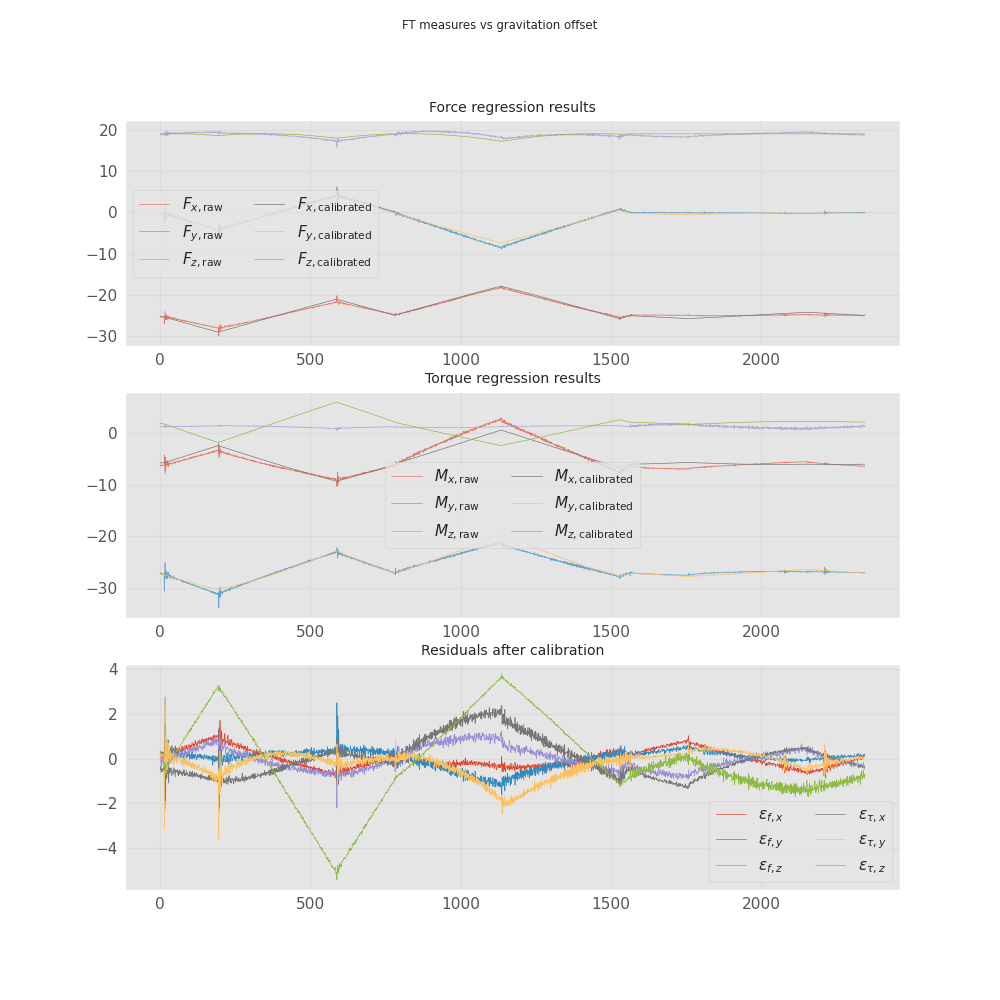

In [8]:
cobot.run_calibration_routine(file_name='/tmp/screwdriver.npy', plot=True, figsize=(10, 10))

### Cobot property API

Below, various examples on the reading APIs are given to access the data from sub-classes 
as needed

In [ ]:
cobot.dt, cobot.hz

In [ ]:
cobot.update_tf()
cobot.B_err_F, cobot.FT_F

## Cobot State handling

the cobot instance checks the current controller-strategy and thus tracks an nternal state, that is None in ```idle``` mode but amy also change to an ```error``` state, once the ```emergecny_stop()``` is triggered:

In [ ]:
cobot.emergency_stop()
print(cobot.state)
cobot.reset()
print(cobot.state)

## Pythonized Hybrid Force-Velocity Control

With the ```cobot.set_py_hybrid_force_vel_command```command below the robot can be set to hybrid force-velocity control to establish a compliant behavior

1. set the command
2. read status
3. apply strategy for fixed time interval

**PLEASE CHECK IF THE FT-SENSOR IS PROPERLY CALIBRATED BEFORE APPLYING THE COMPLIANT CONTROLLER**

In [ ]:
# comment as needed
# ?cobot.set_py_hybrid_force_vel_command

In [ ]:
cobot.init_sns_vel()

In [ ]:
cobot.reset()
cobot.set_py_hybrid_force_vel_command(B_F_des=np.r_[0.0, 0.0, -5, np.zeros(3)], 
                                          K_f=8e-4, K_t=5e-3, scale_pos=0.0, scale_rot=0.0, 
                                      wrench_dir=np.r_[1.0, 1.0, 1.0, np.ones(3)],
                                      vel_dir=np.zeros(6))

In [ ]:
print(cobot)

In [ ]:
# commented for safety reasons -> outcomment for testing
rospy.sleep(2.0)
T = int(10 * cobot.hz)
for t in trange(T):
    cobot.update()

In [ ]:
cobot.B_F_ext

In [ ]:
cobot.emergency_stop()
print(cobot.state)
cobot.reset()
print(cobot.state)

## Compliance via the sensor-track compliance controller

Use the ```set_compliant``` command for an identical behavior as the former function, while only the compliance vector / direction is needed to be set, in addition to the calibration filename to calibrate the cobot properly.

For a current bug, the ```acknowledge_calibration``` needs to be called once more as the robot is currently not accepting the inbuilt service call

**the calibration file defaults to ```/tmp/current.yaml``` so use this with care.**

In [ ]:
# comment as needed
# ?cobot.set_compliant

In [ ]:
cobot.reset()
cobot.set_compliant(np.r_[1.0, 1.0, 1.0, np.zeros(3)], Path("/tmp/current_tool.npy"), F_max=5.0)

In [ ]:
rospy.sleep(0.5)
cobot.acknowledge_calibration()

In [ ]:
T = int(10 * cobot.hz)
for t in trange(T):
    cobot.update()

In [ ]:
cobot.emergency_stop()
print(cobot.state)
cobot.reset()
print(cobot.state)

## Move cobot to a goal pose

Similarly we can also move the robot to a predefined Cartesian Pose via 
```move_to_pose``` command, that is again applied in an identical manner:

1. set the command
2. read status
3. apply strategy for fixed time interval

In [ ]:
# comment as needed
# ?cobot.move_to_pose

In [ ]:
cobot.move_to_pose(cobot.FK(cobot.q_calib))

In [ ]:
print(f"move robot along path of at leaast {np.linalg.norm(cobot.sns_pos- cobot.T_des.t):02.3f} m")

In [ ]:
# commented for safety reasons -> outcomment for testing
T = int(100 * cobot.hz)
for t in trange(T):
    if cobot.state is None:
        rospy.loginfo(f"reached goal pose at step {t + 1} / {T}")
        break
    elif cobot.state == "error":
        rospy.logerror(f"robot in ERROR state")
    cobot.update()

### use motion planner 

In [11]:
import time
cobot.FK(cobot.q)
t0 = time.perf_counter()
cobot.stochastic_move_to_pose(cobot.FK(cobot.q_calib))
print(f'planning and sending took {time.perf_counter() - t0:.3f} [s]')

calculating signed distance field ...
calculating signed distance field done
Elapsed time is 2.294721 seconds.
Elapsed time is 0.063893 seconds.


[rosout][/hrr_cobot_tutorial04] Planner is done and execution is running ...


planning and sending took 2.995 [s]
